# Read data from Rigol DS1054Z scope

https://readthedocs.org/projects/ds1054z/downloads/pdf/stable/

### Import the libraries

In [1]:
from ds1054z import DS1054Z
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.io as sio
import scipy.signal as sig
from scipy.fft import rfft, rfftfreq
import pyvisa as visa
import time
import os
import shutil

### Import local libraries

In [2]:
from appvib import ClSigFeatures
import fcn_scope_ds1054z as scope_ix

### Define plot mode. 
Interactive mode is helpful for visuallizing the program execution

In [3]:
#%matplotlib widget

### Verify scope connection

In [4]:
scope = DS1054Z('192.168.1.206')

In [5]:
print(scope.idn)

RIGOL TECHNOLOGIES,DS1054Z,DS1ZA200902668,00.04.04.SP3


### Test Description

This sheet is designed to take data on a Rigol DS1054z oscilloscope with channel 1 of the scope connected to an MSP6729 magnetic pick up viewing the chuck of a 7" x 10" mini lathe. 

Channel 1 common of the oscilloscope is connected to the magnetic pick up shield wire and the black wire. The signal of channel 1 is connected to the red wire of the mag pick up.

Channel 2 is connect to an eddy-current sensor viewing the case of the lathe.

![alt text](IMG_8440_Scope2MagPickup_Labels.png "Oscilloscope Connections")

#### Verify the help comments are at least somewhat on point

In [6]:
help(scope_ix.b_setup_scope)

Help on function b_setup_scope in module fcn_scope_ds1054z:

b_setup_scope(scope_con, lst_ch_active=[True, False, False, False], lst_ac_coupled=[True, True, True, True], lst_ch_scale=[0.5, 1.0, 1.0, 1.0], timebase_scale=0.05, d_trigger_level=0.1, b_single=True)
    Setup Rigol ds1054z to read data from one or more channels
    
    Keyword arguments:
    scope_con -- Connection to scope. Usually
        the value returned from the 'DS1054Z('192.168.1.206')' call.
    lst_ch_active -- List of booleans describing active channels
        (default: [True, False, False, False] which sets only channel 1
        active).
    lst_ac_coupled -- Boolean list describing ac-coupled state for 
        each channel (default: [True, True, True, True], all channels
        set to AC-coupled)
    lst_ch_scale  -- List with channel scale (default: [5.e-1, 1., 1., 1.] volts)
    timebase_scale -- Time scale for data (default: 0.005 seconds)
    d_trigger_level -- Voltage level to trigger scope (default: 

#### Verify the help text

In [7]:
help(scope_ix.d_get_data)

Help on function d_get_data in module fcn_scope_ds1054z:

d_get_data(scope_con, lst_ch_active=[True, False, False, False], timebase_scale=0.05)
    Get data from the scope
    
    Keyword arguments:
    scope_con -- Scope connection handle (Required). Usually
        the value returned from the 'DS1054Z('192.168.1.206')' call.
    lst_ch_active -- List of booleans describing active channels
        (default: [True, False, False, False] which sets only channel 1
        active). This should exactly match the values used to setup the
        scope.
    timebase_scale -- Scope time scale (default: 5e-2)
    
    Return values:
    lst_d_ch -- list of numpy array of values from the scope:
        [np_d_sig, np_d_ch2, np_d_ch3, np_d_ch4]. If channel
        was not selected for data capture it will be empty ([])



#### Verify help and class structure

In [8]:
help(ClSigFeatures)

Help on class ClSigFeatures in module appvib:

class ClSigFeatures(builtins.object)
 |  ClSigFeatures(np_sig, d_fs)
 |  
 |  Class to manage signal features on scope data and other signals
 |  
 |  Example usage:
 |      cl_test = ClSigFeatures(np.array([1.,2., 3.]),1.1)
 |  
 |  Should produce:
 |  
 |      print('np_d_sig: '+ np.array2string(cl_test.np_d_sig))
 |      print('timebase_scale: ' + '%0.3f' % cl_test.timebase_scale)
 |      print('i_ns: ' + '%3.f' % cl_test.i_ns)
 |      print('d_t_del: ' + '%0.3f' % cl_test.d_t_del)
 |      print('d_time' + np.array2string(cl_test.d_time))
 |  
 |      np_d_sig: [1. 2. 3.]
 |      timebase_scale: 1.000
 |      i_ns:   3
 |      d_t_del: 4.000
 |      d_time[0. 4. 8.]
 |  
 |      Attributes
 |      ----------
 |  
 |      Methods
 |      -------
 |  
 |  Methods defined here:
 |  
 |  __init__(self, np_sig, d_fs)
 |      Parameters
 |      ----------
 |      np_sig : numpy array
 |          Vector with the signal of interest. Can be real

### Setup the test sequence

Seed the sequence, these typically work well for 200-500 RPM and the mag pick-up gapped at 10 mils

In [9]:
str_data_prefix = 'test010'
idx_data = 0
d_timebase_scale = 1e-1
lst_ch_active = [True, True, False, False]
lst_ch_scale=[5.e-1, 2., 1., 1.]

### Acquisition loop
This loop has several steps:

#### Acquire discovery signal
The code does not assume an RPM so it derives it from signal features.

#### Scope setup
Setup the vertical and horizontal scales on the scope. For the first pass, no trigger is used and time scale is set so that at least 2 revolutions of the lathe should be seen in the signal. This lets us see if the signal is valid and how we want to configure the trigger.

#### Initial acquisition
Once the setup is complete acquire the data and push the information into the signal feature class. The speed will be used to set the timescale so that we get about 5 events in the scope window

#### Visualize the data
A few plots are presented of the scope data. Useful for troubleshooting

#### Estimate the speed
With the event frequency known, the scope timebase_scale can be calculated

In [10]:
help(ClSigFeatures.np_d_est_triggers)

Help on function np_d_est_triggers in module appvib:

np_d_est_triggers(self, np_sig_in, i_direction=0, d_threshold=0, d_hysteresis=0.1, b_verbose=False, idx=0)
    This method estimates speed by identifying trigger points in time,
    a given threshold and hysteresis. When the signal level crosses
    the threshold, the trigger holds off. The trigger holds off
    until the signal crosses the hysteresis level. Hysteresis is
    defined relative to the threshold voltage.
    
    The trigger times are a first-order approximation of the instantaneous
    frequency. Most commonly used to estimate the rotating speed from
    magnetic pick-ups or eddy-current probes.
    
    Parameters
    ----------
    np_sig_in : numpy array
        Signal to be evaluated for crossings
    i_direction : integer
        0 to search for threshold on rising signal, 1 to search on a falling signal.
    d_threshold : double
        Threshold value (default: 0.0 volts for zero crossings)
    d_hysteresis : d

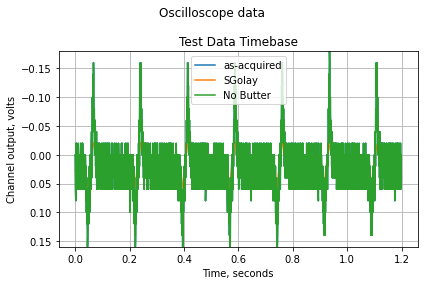

d_thresh_est: 0.1000


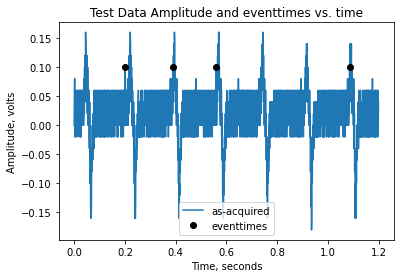

d_timebase_scale (prior to adjustment): 0.100
d_timebase_scale (after adjustment): 0.147
d_pkpk: 0.3400
d_volts_scale: 4.0000
Voltage scale increased


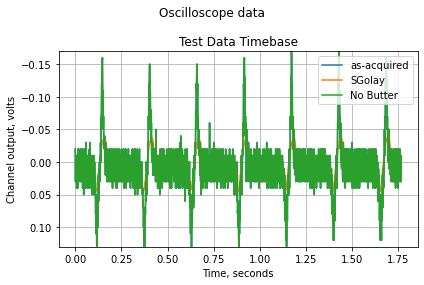

Press Enter to continue...


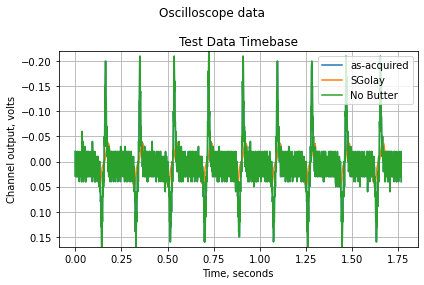

d_thresh_est: 0.0500


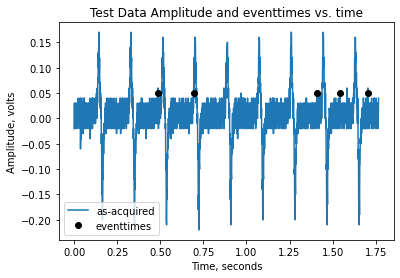

d_timebase_scale (prior to adjustment): 0.147
d_timebase_scale (after adjustment): 0.152
d_pkpk: 0.3900
d_volts_scale: 2.0000
Voltage scale increased


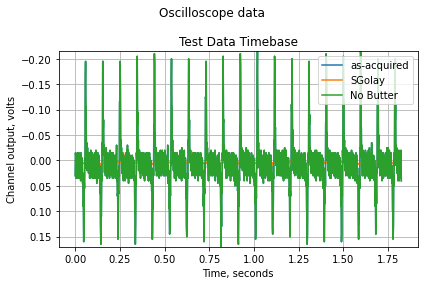

Press Enter to continue...


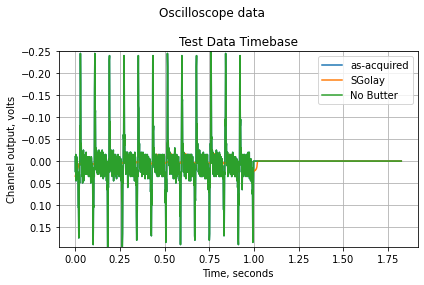

d_thresh_est: 0.0250


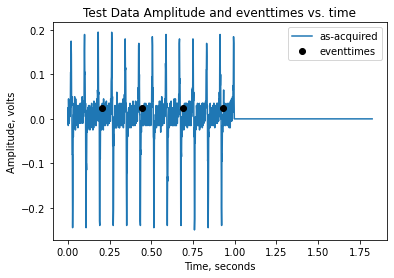

d_timebase_scale (prior to adjustment): 0.152
d_timebase_scale (after adjustment): 0.122
d_pkpk: 0.4450
d_volts_scale: 1.0000
Voltage scale increased


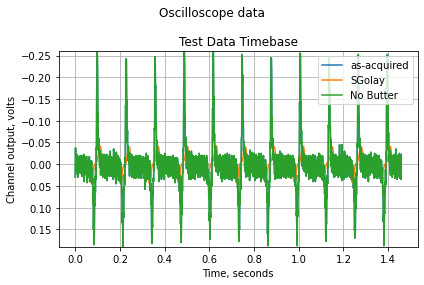

Press Enter to continue...


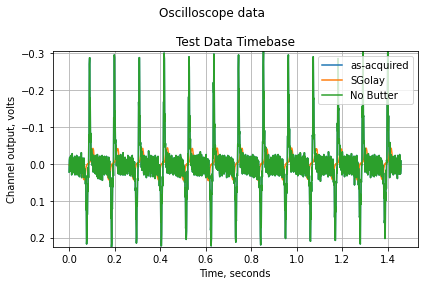

d_thresh_est: 0.0125


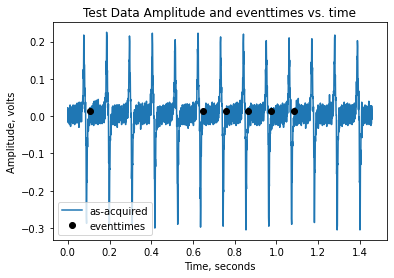

d_timebase_scale (prior to adjustment): 0.122
d_timebase_scale (after adjustment): 0.098
d_pkpk: 0.5300
d_volts_scale: 0.5000
Voltage scale reduced


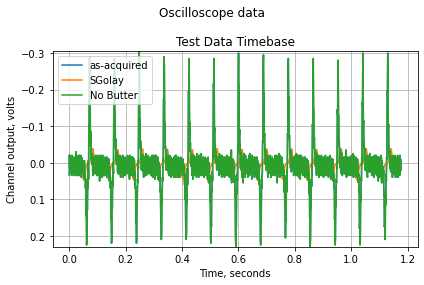

Press Enter to continue...


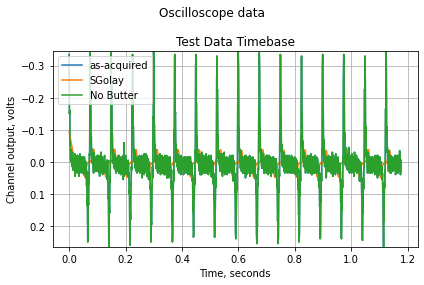

d_thresh_est: 0.0250


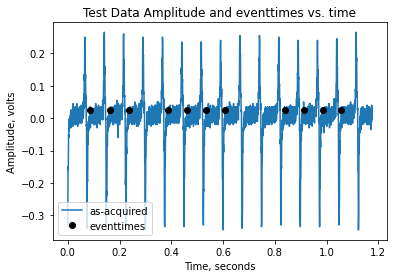

d_timebase_scale (prior to adjustment): 0.098
d_timebase_scale (after adjustment): 0.049
d_pkpk: 0.6100
d_volts_scale: 1.0000


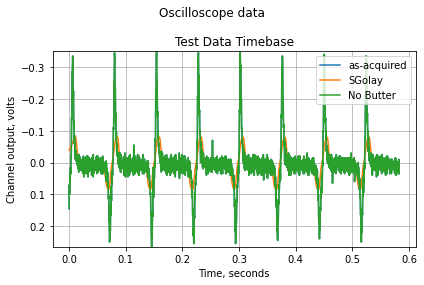

Press Enter to continue...


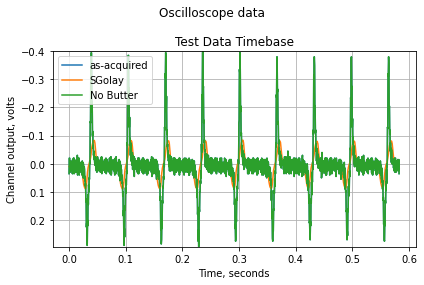

d_thresh_est: 0.0250


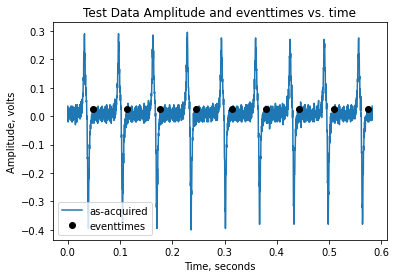

d_timebase_scale (prior to adjustment): 0.049
d_timebase_scale (after adjustment): 0.033
d_pkpk: 0.6950
d_volts_scale: 1.0000


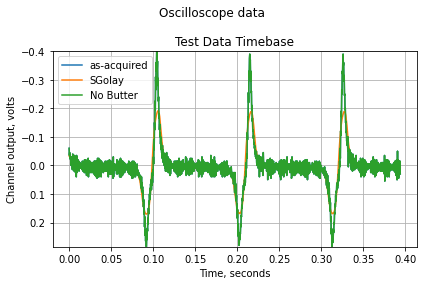

Press Enter to continue...


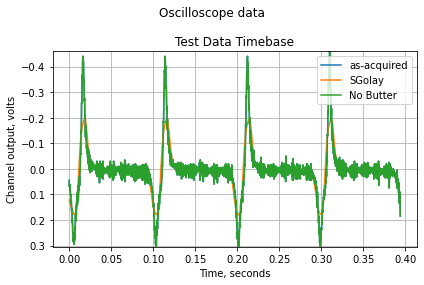

d_thresh_est: 0.0250


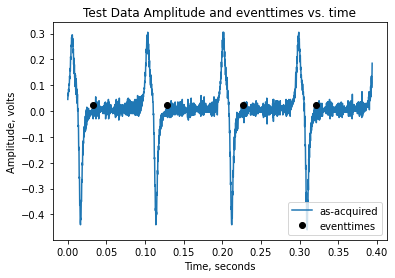

d_timebase_scale (prior to adjustment): 0.033
d_timebase_scale (after adjustment): 0.048
d_pkpk: 0.7650
d_volts_scale: 1.0000


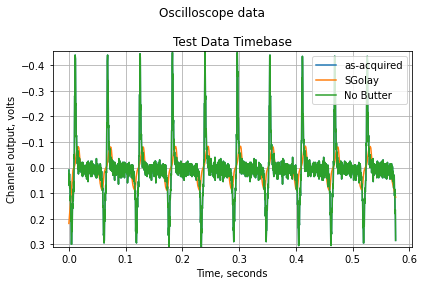

Press Enter to continue...


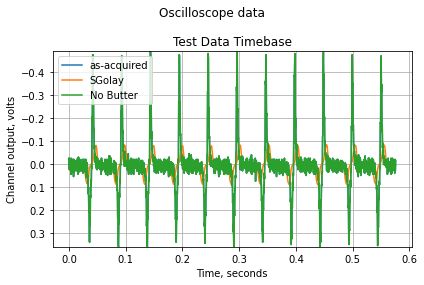

d_thresh_est: 0.0250


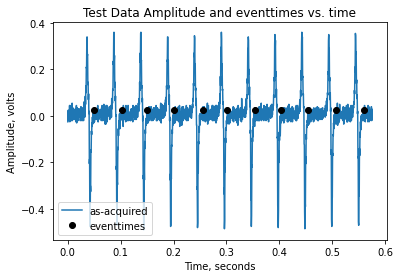

d_timebase_scale (prior to adjustment): 0.048
d_timebase_scale (after adjustment): 0.026
d_pkpk: 0.8500
d_volts_scale: 1.0000


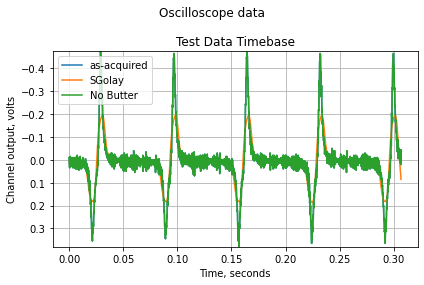

Press Enter to continue...


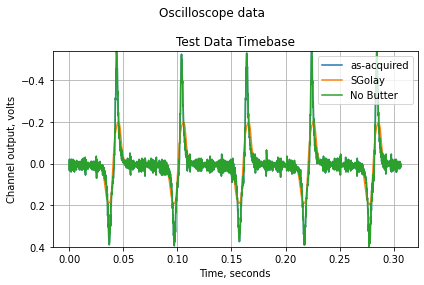

d_thresh_est: 0.0250


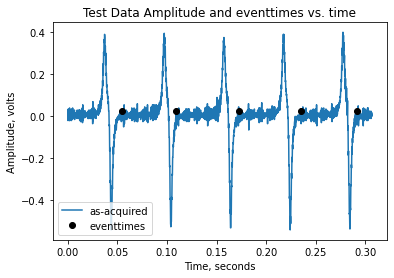

d_timebase_scale (prior to adjustment): 0.026
d_timebase_scale (after adjustment): 0.030
d_pkpk: 0.9400
d_volts_scale: 1.0000


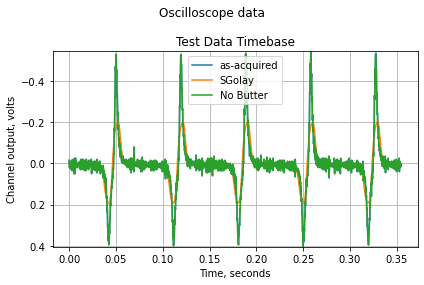

Press Enter to continue...


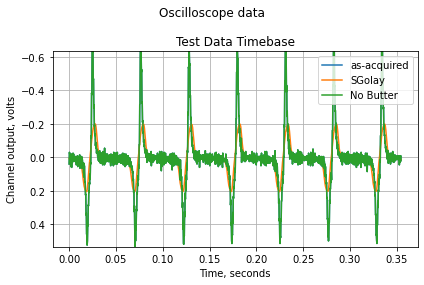

d_thresh_est: 0.0250


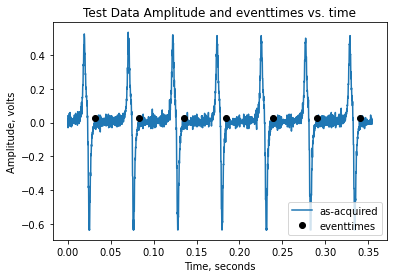

d_timebase_scale (prior to adjustment): 0.030
d_timebase_scale (after adjustment): 0.026
d_pkpk: 1.1700
d_volts_scale: 1.0000
Voltage scale reduced


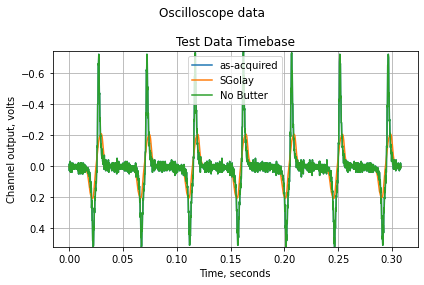

Press Enter to continue...


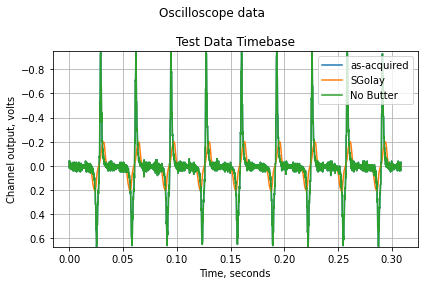

d_thresh_est: 0.0500


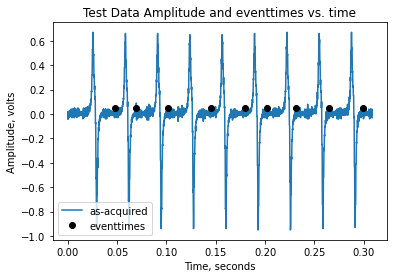

d_timebase_scale (prior to adjustment): 0.026
d_timebase_scale (after adjustment): 0.016
d_pkpk: 1.6200
d_volts_scale: 2.0000


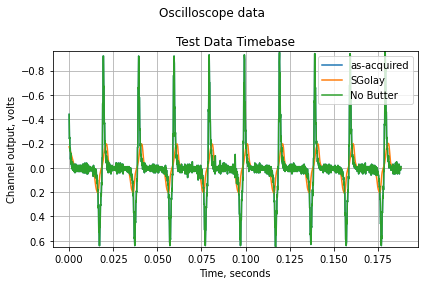

Press Enter to continue...


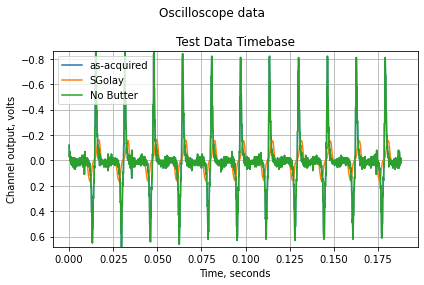

d_thresh_est: 0.0500


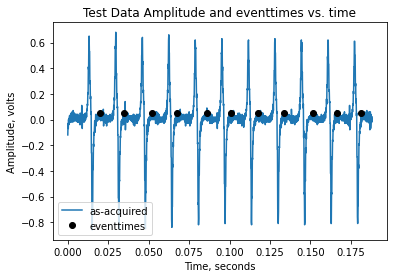

d_timebase_scale (prior to adjustment): 0.016
d_timebase_scale (after adjustment): 0.008
d_pkpk: 1.5400
d_volts_scale: 2.0000


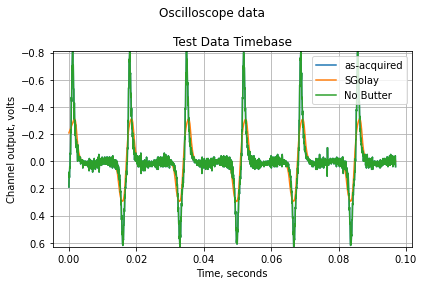

Press Enter to continue...


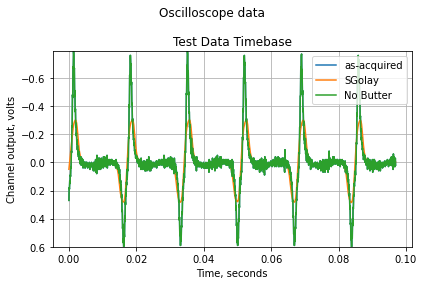

d_thresh_est: 0.0500


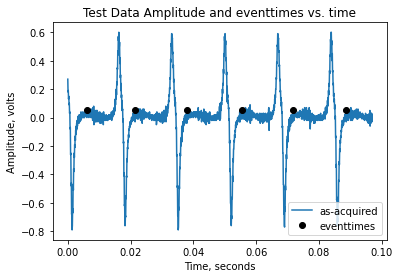

d_timebase_scale (prior to adjustment): 0.008
d_timebase_scale (after adjustment): 0.008
d_pkpk: 1.3900
d_volts_scale: 2.0000


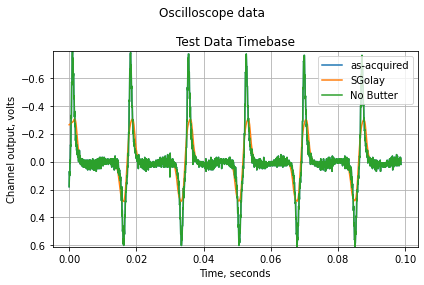

KeyboardInterrupt: Interrupted by user

In [11]:
while True:
    
    # Setup the scope for the trial sample acquisition, both channels
    d_ch1_scale = scope_ix.b_setup_scope(scope, lst_ch_scale=lst_ch_scale, lst_ch_active = lst_ch_active,
          timebase_scale=d_timebase_scale, d_trigger_level = 1e-01, b_single = False)
    
    # Acquire the test samples
    lst_d_ch = scope_ix.d_get_data(scope_con=scope, lst_ch_active = lst_ch_active, 
                timebase_scale=d_timebase_scale)
    
    # Instatiate the class, send the waveform samples and scales
    d_t_del = scope_ix.d_get_delta_time(d_timebase_scale, len(lst_d_ch[0]))
    cl_sig_no_trigger = ClSigFeatures(lst_d_ch[0], 1./d_t_del)
    cl_sig_no_trigger.np_d_ch2 = lst_d_ch[1]
    
    # Plot out the signal
    hp = cl_sig_no_trigger.plt_sigs()
    
    # The shape of the response is similar as speed increased, but the
    # triggering threshold has to increase to accomodate the higher
    # amplitudes
    d_thresh_est = 0.1 * (d_ch1_scale/0.5)
    print('d_thresh_est: ' + '%0.4f' % d_thresh_est)
    
    # Calculate the trigger event times
    np_d_eventtimes = cl_sig_no_trigger.np_d_est_triggers(np_sig_in=cl_sig_no_trigger.np_d_sig, 
                                                          i_direction=0, 
                                                          d_threshold=d_thresh_est, 
                                                          d_hysteresis=0.2, b_verbose=False)
    np_d_eventtimes
    
    # Visualize the eventtimes
    hp = cl_sig_no_trigger.plt_eventtimes()
    
    # Calculated the desired timebase_scale
    print("d_timebase_scale (prior to adjustment): " '%0.3f' % d_timebase_scale)
    d_timebase_scale = (6./12.)*(np.mean(np.diff(np_d_eventtimes)))
    print("d_timebase_scale (after adjustment): " '%0.3f' % d_timebase_scale)
    
    # Check for clipping and correct scaling. The scope has 8 vertical division so the 
    # total voltage range on the screen is 8 * d_ch1_scale 
    d_pkpk = np.max(lst_d_ch[0]) - np.min(lst_d_ch[0])
    print("d_pkpk: " + "%0.4f" % d_pkpk)
    d_volts_scale = (8*d_ch1_scale)
    print("d_volts_scale: " + "%0.4f" % d_volts_scale)
    if ( d_pkpk > d_volts_scale ):
        print("Voltage scale reduced")
        d_ch1_scale = d_ch1_scale*2.
    
    # Could be the vertical scale is too small, check for that
    if ( abs( d_volts_scale/d_pkpk > 2. )):
        print("Voltage scale increased")
        d_ch1_scale = d_ch1_scale/2.
    
    # The scope trigger setting scales with the overall amplitude since the
    # shape of the response is similar
    d_trigger_level_est = 0.2 * (d_ch1_scale/0.5)
    
    # Reset the scope with the adjusted features, set to trigger on single sample
    lst_ch_scale[0] = d_ch1_scale
    d_ch1_scale = scope_ix.b_setup_scope(scope, lst_ch_scale=lst_ch_scale, lst_ch_active = lst_ch_active,
          timebase_scale=d_timebase_scale, d_trigger_level = 1e-01, b_single = True)    
    
    # Acquire the sample
    lst_d_ch = scope_ix.d_get_data(scope_con=scope, lst_ch_active = lst_ch_active, 
                timebase_scale=d_timebase_scale)
    
    # Reset back to free-run
    scope_ix.b_setup_scope(scope_con=scope, lst_ch_scale=lst_ch_scale, lst_ch_active = lst_ch_active,
              timebase_scale=d_timebase_scale, d_trigger_level = 1e-01, b_single = False)

    # Instatiate the class, send the waveform samples and scales
    d_t_del = scope_ix.d_get_delta_time(d_timebase_scale, len(lst_d_ch[0]))
    cl_sig_no_trigger = ClSigFeatures(lst_d_ch[0], 1./d_t_del)
    cl_sig_no_trigger.np_d_ch2 = lst_d_ch[1]

    # Visualize the data
    hp = cl_sig_no_trigger.plt_sigs()
        
    # Save it off to a file    
    b_file_save = cl_sig_no_trigger.b_save_data(str_data_prefix = str_data_prefix, idx_data = idx_data)
        
    # Wait for the next speed adjustment and continue
    idx_data += 1
    time.sleep(2)
    input("Press Enter to continue...")